# Persistent Homology KNN Demo

## Simplicial Complex Object

Simplicial Complexes can be completely specified by a connectivity graph, where the simplicies are defined by the edges of the graph.

The graph is constructed form a set of points and a radius $r$. If two points lie within $r$ of each other, then the two points are connected via an edge. Simplicies of dimension $n$ are then defined as a set of $n$ pairwise connected points.

In the `SimplicialComplex` object, we can import the set of points in the complex and specify a radius. This is enough to create a simplicial complex. 

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
from simplicial_complex import SimplicialComplex
from persistent_homology_knn import PHKnn

In [2]:
#import data as numpy array
with open('../Data/torus_points.txt') as f:
    data = np.loadtxt(f, delimiter=',')

#create simplicial complex object
sc = SimplicialComplex(radius=0.5,
                       vertices=data)
sc

The simplicial complex is stored in memory as a `networkx` undirected, weighted graph as `SimplicialComplex.complex` (with distance between nodes acting as the weights). Thus, we can conduct graph operations on the complex. The `SimplicialComplex` object acts as a wrapper to a `networkx` graph, with added logic to ensure that the nodes and weights remain faithful to a representation of a simplical complex.

A useful graph operation to conduct might be the `networkx.draw` function, which gives us a visual representation of our complex as a graph:

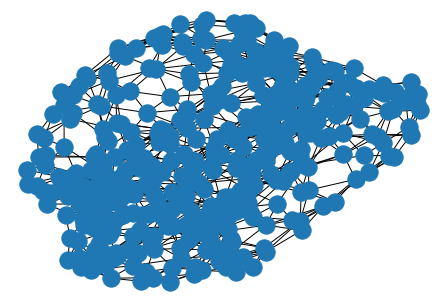

In [3]:
nx.draw(sc.complex)
plt.show()

The distance between two points need not be the standard euclidean distance. With the `graph_distance_metric` parameter, we can give `SimplicialComplex` a new distance metric to use (the default value of this parameter is the euclidean distance). The only requirements are that the metric take two numpy arrays as output and return a scalar value:

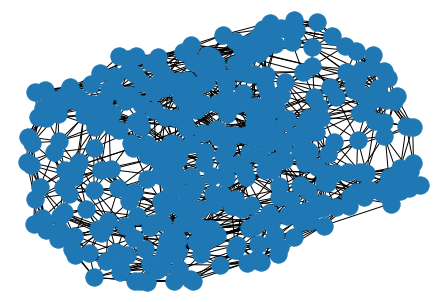

In [4]:
taxicab  = lambda x,y: np.sum(np.abs(x-y))
sc_taxi = SimplicialComplex(radius=1, vertices=data, graph_distance_metric=taxicab)
nx.draw(sc_taxi.complex)
plt.show()

Eventually we would like to conduct KNN on the simplical complex. Thus, it might be useful to have the weights between nodes be different from the distance used to determine connectivity. This can be done by specifying `weight_distance_metric`, which by default equals `graph_distance_metric`. Thus, `graph_distance_metric` determines the connectivity between points and `weight_distance_metric` specifies the weight of the edge between them.

In [5]:
taxicab  = lambda x,y: np.sum(np.abs(x-y))
euclidean = lambda x,y: np.linalg.norm(x-y)
sc = SimplicialComplex(radius=1, vertices=data, graph_distance_metric=taxicab, weight_distance_metric=euclidean)

Finally, we can always add or remove vertices from the complex:

In [6]:
new_point = np.array((1,1,1,1))
sc.add_point(new_point)
sc.has_point(new_point)

True

In [7]:
sc.remove_point(new_point)
sc.has_point(new_point)

False

## Persistent homology KNN demo

The `PHKnn` object conducts the knn algorithm on distances defined by a simplicial complex, which is itself implemented as a `SimplicialComplex` object. To construct the classifier, we must provide a radius $r$ to define the simplex, a number $k$ to define the number of nearest neighbors to consider, and optionally `graph_distance_metric` and `weight_distance_metric` to define the simplex. The latter two arguments always default to the euclidean distance metric.

In [8]:
#create training data
X = data
y = []
for x in X:
    y.append(random.choice([1,0]))
y = np.array(y)

In [9]:
classifier = PHKnn(radius=1, k=5)
classifier.fit(X,y)

To predict using the classifier, we simply provide a numpy matrix of points to classify to the `predict` method:

In [10]:
test = np.array(
    [[1,0,1,0],
    [0,1,0,0],
    [-1,-1,-1,-1]])
classifier.predict(test)

[1, 1, 0]

Each entry of the return value corresponds to the point in `test` with the same index. This knn method has the important feature that it can fail:

In [11]:
classifier.predict(np.array([0,0,0,0]))

Only 1 neighbors to point [0 0 0 0] found, at least 5 needed for classification.
 This indicates that the data matrix is too sparse near [0 0 0 0] for a successful classification


[None]

The neighors to a point are all nodes in the simplicial complex which have a path to the point, if the point were added to the complex. Thus, if the data is too sparse near a point we wish to classify, there simply won't be enough connected components to find $k$ neighbors. This is not necessarily a bad thing, since it can give an indication that:
- We misunderstood the intrinsic geometry of the classification problem. Thus, we need to re-think the distance metrics we use to define the "nearness" of points
- The data is simply too sparse to conduct a classification for a given point and attempting to classify with any algorithm would be misleading. Thus, we should reduce the dimensionality of the data, or collect more data.